Optimal periods at 70.0℃, 1.031 um:
  SHG Period (Λ_SHG): 7.2017 um
  SFG Period (Λ_SFG): 1.9591 um

Pre-calculating delta_k values for THG simulation...
Delta_k calculation complete: 0.2197 seconds

JIT compiling...
Compilation complete.
Calculation complete (Cascade): 1.1046 seconds
Calculation complete (SHG-only): 0.6946 seconds


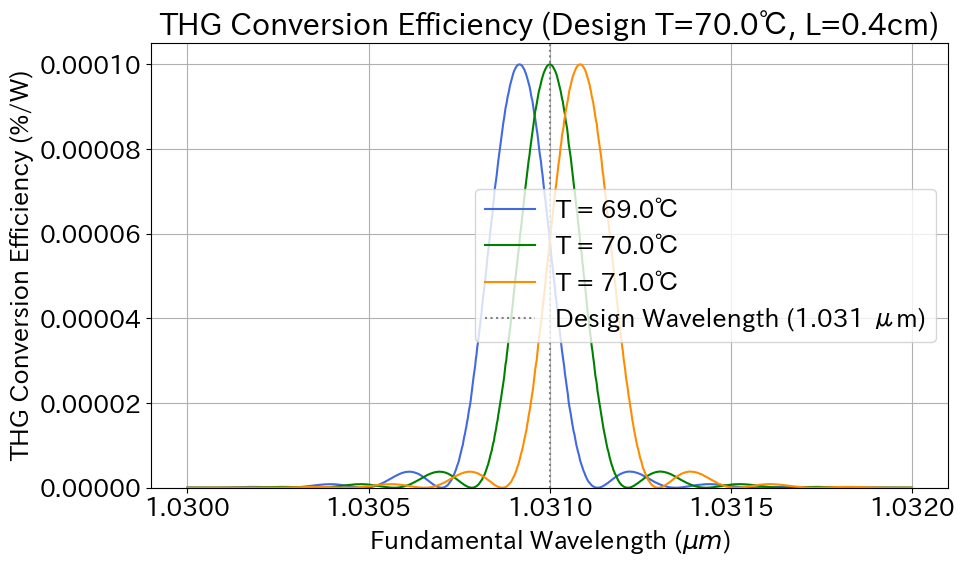

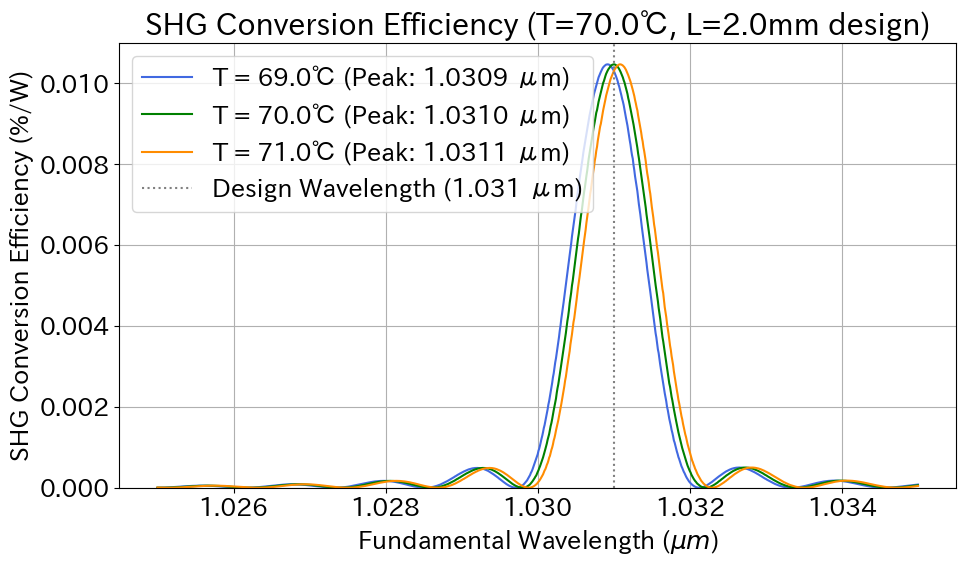

In [ ]:
import time

import japanize_matplotlib  # pyright: ignore[reportMissingTypeStubs, reportUnusedImport]
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, vmap

from qpm import cwes, grating, mgoslt

# --- 定数設定 (Constants) ---
Z_SPLIT = 2000.0  # SHGセクションとSFGセクションの境界 (Boundary between SHG and SFG sections) (um)
Z_MAX = Z_SPLIT * 2.2  # 結晶の全長 (Total length of the crystal) (um)
KAPPA_MAG = 1.31e-5  # 非線形結合係数 (Nonlinear coupling coefficient)
DESIGN_TEMP_C = 70.0  # 設計温度 (Design temperature for QPM period calculation) (°C)
DESIGN_WAVELENGTH = 1.031  # 設計波長 (Design wavelength for QPM period calculation) (um)


def simulate_mgoslt_twm_optimized(superlattice: jnp.ndarray, delta_k1: jnp.ndarray, delta_k2: jnp.ndarray) -> jnp.ndarray:
    b_initial = jnp.array([1.0, 0.0, 0.0], dtype=jnp.complex64)
    b_final = cwes.simulate_twm(superlattice, delta_k1, delta_k2, b_initial)
    # Return SHG and THG conversion efficiencies
    return jnp.abs(b_final[1:3]) ** 2


def simulate_mgoslt_twm(superlattice: jnp.ndarray, temperature: jnp.ndarray, wavelength: jnp.ndarray) -> jnp.ndarray:
    delta_k1 = mgoslt.calc_twm_delta_k(wavelength, wavelength, temperature)
    delta_k2 = mgoslt.calc_twm_delta_k(wavelength, wavelength / 2.0, temperature)
    return simulate_mgoslt_twm_optimized(superlattice, delta_k1, delta_k2)


def run_simulation(
    superlattices: jnp.ndarray,
    temperatures: jnp.ndarray,
    wavelengths_narrow: jnp.ndarray,
    wavelengths_wide: jnp.ndarray,
) -> dict[str, jnp.ndarray]:
    """
    Executes the JAX-based simulation for the given parameters.

    Args:
        superlattices: A stacked array of different superlattice structures.
        temperatures: An array of temperatures to simulate.
        wavelengths_narrow: Wavelength range for THG simulation.
        wavelengths_wide: Wavelength range for SHG simulation.

    Returns:
        A dictionary containing the simulation results for SHG and THG efficiencies.
    """
    # Pre-calculate all delta_k values for narrow wavelengths (THG simulation)
    print("\nPre-calculating delta_k values for THG simulation...")
    start_time_delta_k = time.time()

    # Create meshgrids for vectorized delta_k calculation
    temp_mesh_narrow, wl_mesh_narrow = jnp.meshgrid(temperatures, wavelengths_narrow, indexing="ij")
    delta_k1_narrow = mgoslt.calc_twm_delta_k(wl_mesh_narrow, wl_mesh_narrow, temp_mesh_narrow)
    delta_k2_narrow = mgoslt.calc_twm_delta_k(wl_mesh_narrow, wl_mesh_narrow / 2.0, temp_mesh_narrow)

    # Create meshgrids for wide wavelengths (SHG simulation)
    temp_mesh_wide, wl_mesh_wide = jnp.meshgrid(temperatures, wavelengths_wide, indexing="ij")
    delta_k1_wide = mgoslt.calc_twm_delta_k(wl_mesh_wide, wl_mesh_wide, temp_mesh_wide)
    delta_k2_wide = mgoslt.calc_twm_delta_k(wl_mesh_wide, wl_mesh_wide / 2.0, temp_mesh_wide)

    print(f"Delta_k calculation complete: {time.time() - start_time_delta_k:.4f} seconds")

    # Vectorize the optimized simulation function
    vmapped_simulate_optimized = jit(
        vmap(vmap(vmap(simulate_mgoslt_twm_optimized, in_axes=(None, 0, 0)), in_axes=(None, 0, 0)), in_axes=(0, None, None))
    )

    # --- JIT Compilation ---
    print("\nJIT compiling...")
    # Run with dummy data to complete compilation
    vmapped_simulate_optimized(superlattices, delta_k1_narrow, delta_k2_narrow).block_until_ready()
    print("Compilation complete.")

    # --- Run Cascade Structure Simulation (for THG) ---
    start_time_cascade = time.time()
    results_cascade = vmapped_simulate_optimized(superlattices[0:1], delta_k1_narrow, delta_k2_narrow)
    results_cascade_squeezed = jnp.squeeze(results_cascade.block_until_ready(), axis=0)
    # Convert to %/W
    thg_efficiencies = results_cascade_squeezed[:, :, 1] * 100
    print(f"Calculation complete (Cascade): {time.time() - start_time_cascade:.4f} seconds")

    # --- Run SHG-only Structure Simulation ---
    start_time_shg = time.time()
    results_shg_only = vmapped_simulate_optimized(superlattices[1:2], delta_k1_wide, delta_k2_wide)
    results_shg_only = results_shg_only * 1.07 / 2.84  # Correction factor
    results_shg_squeezed = jnp.squeeze(results_shg_only.block_until_ready(), axis=0)
    # Convert to %/W
    shg_efficiencies_wide = results_shg_squeezed[:, :, 0] * 100
    print(f"Calculation complete (SHG-only): {time.time() - start_time_shg:.4f} seconds")

    return {"thg_efficiencies": thg_efficiencies, "shg_efficiencies": shg_efficiencies_wide}


def plot_results(
    results: dict[str, jnp.ndarray],
    wavelengths: dict[str, jnp.ndarray],
    temperatures: jnp.ndarray,
    design_params: dict[str, float | int],
) -> None:
    """
    Plots the simulation results for THG and SHG efficiencies.

    Args:
        results: A dictionary containing the efficiency results.
        wavelengths: A dictionary of wavelength arrays used for simulation.
        temperatures: An array of temperatures used.
        design_params: A dictionary with design parameters for annotating the plot.
    """
    colors = ["royalblue", "green", "darkorange"]
    plt.rcParams["font.size"] = 18

    # --- Plot THG Conversion Efficiency ---
    plt.figure(figsize=(10, 6))
    plt.title(f"THG Conversion Efficiency (Design T={design_params['temp']}℃, L={design_params['length']:.1f}cm)")

    for i, temp in enumerate(temperatures):
        plt.plot(wavelengths["narrow"], results["thg_efficiencies"][i], label=f"T = {temp}℃", color=colors[i])

    plt.axvline(x=design_params["wavelength"], color="gray", linestyle=":", label=f"Design Wavelength ({design_params['wavelength']} μm)")
    plt.xlabel(r"Fundamental Wavelength ($\mu m$)")
    plt.xticks(jnp.arange(1.03, 1.032, 0.0005))
    plt.ylabel(r"THG Conversion Efficiency (%/W)")
    plt.legend()
    plt.grid(visible=True)
    plt.ylim(bottom=0)
    plt.tight_layout()

    # --- Plot SHG Conversion Efficiency ---
    plt.figure(figsize=(10, 6))
    plt.title(f"SHG Conversion Efficiency (T={design_params['temp']}℃, L={design_params['shg_length']:.1f}mm design)")

    for i, temp in enumerate(temperatures):
        peak_idx = jnp.argmax(results["shg_efficiencies"][i])
        peak_wl = wavelengths["wide"][peak_idx]
        plt.plot(wavelengths["wide"], results["shg_efficiencies"][i], label=f"T = {temp}℃ (Peak: {peak_wl:.4f} μm)", color=colors[i])

    plt.axvline(x=design_params["wavelength"], color="gray", linestyle=":", label=f"Design Wavelength ({design_params['wavelength']} μm)")
    plt.xlabel(r"Fundamental Wavelength ($\mu m$)")
    plt.ylabel(r"SHG Conversion Efficiency (%/W)")
    plt.legend()
    plt.grid(visible=True)
    plt.ylim(bottom=0)
    plt.tight_layout()

    plt.show()


def main() -> None:
    """Main function to set up parameters, run simulation, and plot results."""
    # --- Parameter Setup ---
    wavelengths_narrow = jnp.linspace(1.03, 1.032, 1001)
    wavelengths_wide = jnp.linspace(1.025, 1.035, 1001)
    temperatures = jnp.array([69.0, 70.0, 71.0])

    # 1. Calculate phase mismatch at design conditions
    delta_k_shg_design = mgoslt.calc_twm_delta_k(DESIGN_WAVELENGTH, DESIGN_WAVELENGTH, DESIGN_TEMP_C)
    delta_k_sfg_design = mgoslt.calc_twm_delta_k(DESIGN_WAVELENGTH, DESIGN_WAVELENGTH / 2.0, DESIGN_TEMP_C)

    # 2. Calculate optimal QPM periods
    qpm_period_shg = 2 * jnp.pi / delta_k_shg_design
    qpm_period_sfg = 2 * jnp.pi / delta_k_sfg_design

    print(f"Optimal periods at {DESIGN_TEMP_C}℃, {DESIGN_WAVELENGTH} um:")
    print(f"  SHG Period (Λ_SHG): {qpm_period_shg:.4f} um")
    print(f"  SFG Period (Λ_SFG): {qpm_period_sfg:.4f} um")

    # 3. Generate QPM grating components (using grating.build with domain counts)
    # Compute domain counts
    domain_len_shg = qpm_period_shg / 2.0
    num_domains_shg = int(jnp.floor(Z_SPLIT / domain_len_shg).item())

    domain_len_sfg = qpm_period_sfg / 2.0
    num_domains_sfg = int(jnp.floor((Z_MAX - Z_SPLIT) / domain_len_sfg).item())

    # Split point for SHG
    shg_len = Z_SPLIT
    split_len = 0.165 * shg_len
    split_idx = int(jnp.floor(split_len / domain_len_shg).item())
    split_idx = max(0, min(split_idx, num_domains_shg))

    # Profiles for structures
    # Cascade (SHG with flipped second segment, then SFG)
    profiles_cascade = [
        grating.uniform_profile(num_domains=split_idx, period=qpm_period_shg, kappa_mag=KAPPA_MAG),
        grating.uniform_profile(num_domains=num_domains_shg - split_idx, period=qpm_period_shg, kappa_mag=-KAPPA_MAG),
        grating.uniform_profile(num_domains=num_domains_sfg, period=qpm_period_sfg, kappa_mag=KAPPA_MAG),
    ]

    # SHG-only (full SHG then blank)
    profiles_shg_only = [
        grating.uniform_profile(num_domains=num_domains_shg, period=qpm_period_shg, kappa_mag=KAPPA_MAG),
        grating.uniform_profile(num_domains=num_domains_sfg, period=qpm_period_sfg, kappa_mag=0.0),
    ]

    # Build sections
    superlattice_cascade = grating.build(profiles_cascade)
    superlattice_shg_only = grating.build(profiles_shg_only)

    # 4. Pad and stack
    lattices = [superlattice_cascade, superlattice_shg_only]
    max_len = max(lattice.shape[0] for lattice in lattices)
    superlattices = jnp.stack([jnp.concatenate([lattice, jnp.zeros((max_len - lattice.shape[0], 2), dtype=lattice.dtype)]) for lattice in lattices])

    # 5. Run simulation
    simulation_results = run_simulation(superlattices, temperatures, wavelengths_narrow, wavelengths_wide)

    # 6. Plot results
    plot_params = {
        "results": simulation_results,
        "wavelengths": {"narrow": wavelengths_narrow, "wide": wavelengths_wide},
        "temperatures": temperatures,
        "design_params": {
            "wavelength": DESIGN_WAVELENGTH,
            "temp": DESIGN_TEMP_C,
            "length": Z_MAX / 10000.0,  # um to cm
            "shg_length": Z_SPLIT / 1000.0,  # um to mm
        },
    }
    plot_results(**plot_params)  # pyright: ignore[reportArgumentType]


if __name__ == "__main__":
    main()


0.010330084 2.8974112e-10


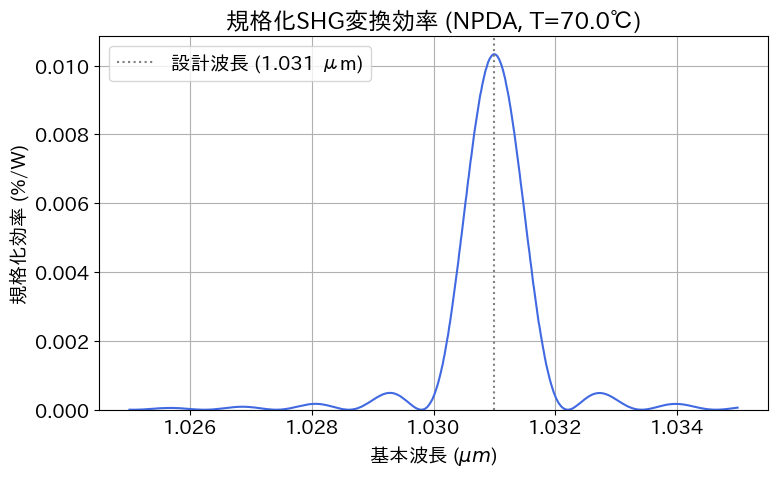

In [2]:
import japanize_matplotlib  # pyright: ignore[reportMissingTypeStubs, reportUnusedImport]
import jax.numpy as jnp
import matplotlib.pyplot as plt

from qpm import mgoslt

# --- 基本設定 ---
L_SHG = 2000.0  # SHG結晶長 (um)
DESIGN_TEMP_C = 70.0  # 設計温度 (℃)
DESIGN_WAVELENGTH = 1.031  # 設計波長 (um)
TARGET_TEMP_C = 70.0  # 計算対象の温度 (℃)

# --- 波長とκ(kappa)の範囲設定 ---
WL_START, WL_END = 1.025, 1.035
KAPPA_START, KAPPA_END = 1.30756e-5, 1.29579e-5

# --- 位相整合条件を計算 ---
# 設計条件での (k_2ω - 2k_ω) が格子ベクトル K_g に対応
K_g = mgoslt.calc_twm_delta_k(DESIGN_WAVELENGTH, DESIGN_WAVELENGTH, DESIGN_TEMP_C)

# --- スペクトル計算 (JAX配列演算) ---
# 1. 波長配列を生成
wavelengths = jnp.linspace(WL_START, WL_END, 1001)

# 2. 波長に応じて線形に変化するκ(lambda)を計算
kappa = KAPPA_START + (KAPPA_END - KAPPA_START) * (wavelengths - WL_START) / (WL_END - WL_START)

# 3. 全体の位相不整合 Δk を計算
delta_k_material = mgoslt.calc_twm_delta_k(wavelengths, wavelengths, TARGET_TEMP_C)
delta_k_total = delta_k_material - K_g

# 4. ご提示の式に従って規格化効率を計算
sinc_squared_part = jnp.sinc(delta_k_total * L_SHG / (2 * jnp.pi)) ** 2
efficiency_norm = (kappa**2) * (L_SHG**2) * sinc_squared_part * 100
efficiency_norm = efficiency_norm * 1.07 / 2.84  # 野呂さんの行っていたガウシアンのための補正
# NOTE: この項は野呂さんの計算には含まれないが、おそらく理論的に必要。野呂さんの結果と照らし合わせる場合は不要
efficiency_norm = efficiency_norm * (2 / jnp.pi) ** 2  # NPDAは微分方程式の解の2/pi倍になるため補正

print(jnp.max(efficiency_norm), jnp.min(efficiency_norm))
# --- プロット ---
plt.rcParams["font.size"] = 14
plt.figure(figsize=(8, 5))
plt.title(f"規格化SHG変換効率 (NPDA, T={TARGET_TEMP_C}℃)")
plt.plot(wavelengths, efficiency_norm, color="royalblue")
plt.axvline(x=DESIGN_WAVELENGTH, color="gray", linestyle=":", label=f"設計波長 ({DESIGN_WAVELENGTH} μm)")
plt.xlabel(r"基本波長 ($\mu m$)")
plt.ylabel(r"規格化効率 (%/W)")
plt.legend()
plt.grid(visible=True)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()